In [1]:
import pandas as pd
import numpy as np
import joblib
import sklearn
# import ensemble
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error,balanced_accuracy_score,recall_score
import random
import lightgbm as lgb
import catboost as cbt
import xgboost as xgb

In [2]:
def incr_act_top10(input_df,pred_col,cm_key='customer',treated_col='ind_recommended',actual_col='activation'):
    
	#for correcting variable types
    input_df[[treated_col, actual_col, pred_col]] = input_df[[treated_col, actual_col, pred_col]].apply(pd.to_numeric, errors='coerce')
	
    input_df['rank_per_cm1'] = input_df.groupby(cm_key)[pred_col].rank(method='first', ascending=False)
    
    input_df = input_df.loc[input_df.rank_per_cm1 <= 10,:]
    
    agg_df = input_df.groupby(treated_col,as_index=False).agg({actual_col:'mean'})
    agg_df.columns = [treated_col,'avg_30d_act']
    
    print(agg_df)
    recommended_avg_30d_act = float(agg_df.loc[agg_df[treated_col]==1,'avg_30d_act'])
    not_recommended_avg_30d_act = float(agg_df.loc[agg_df[treated_col]==0,'avg_30d_act'])
    
    return (recommended_avg_30d_act-not_recommended_avg_30d_act)


def eval(df_input, df_round): 
    # round off scores to 10 decimal points
    df_input['predicted_score'] = df_input['predicted_score'].round(10)


    # groupby customer, merchant and max score
    df_input = df_input.groupby(['customer', 'merchant'], as_index = False)['predicted_score'].agg('max')


    # merging predicted file and dependent variable file
    eval_data = pd.merge(df_round,df_input,on=['customer','merchant'],how='inner').drop_duplicates()
    # deleting the rows having null value in predicted_score
    eval_data = eval_data[~(eval_data['predicted_score'].isna())]


    if df_round.shape[0] != eval_data.shape[0]:
        return('Error: Rows are missing in the output file')
    else:
        print('Input Files are Correct')

    final_score = round(incr_act_top10(input_df=eval_data,pred_col='predicted_score',cm_key='customer',treated_col='ind_recommended',actual_col='activation'), 7)

    print('Incremental Activation Rate for Top 10 ranked Merchants(dataset level): ', final_score)

In [70]:
data = pd.read_csv("Data/Training/bilkulfirstaayenge.csv")
# data = pd.read_parquet("Data/Training/Amex_Campus_Challenge_Train.parquet")

In [71]:
randomlist = random.sample(list(data.customer.unique()),int(0.1*len(data.customer.unique())))

In [72]:
testdata = data[data['customer'].isin(randomlist)]

In [73]:
#select rows whose column value is not in a list
# traindata = data[~data['customer'].isin(randomlist)]
traindata = data

In [74]:
del data

In [75]:
def confusion_matrix_2col(df, col1, col2):
    return df.groupby([col1, col2]).size().unstack(fill_value=0)

confusion_matrix_2col(traindata, 'ind_recommended', 'activation')

activation,0,1
ind_recommended,,
0,292879,60173
1,80162,9843


In [76]:
from pylift import TransformedOutcome 

In [77]:
traindata.groupby('activation')['ind_recommended'].count()

activation
0    373041
1     70016
Name: ind_recommended, dtype: int64

In [78]:
traindata = traindata.drop(traindata[(traindata['activation'] == 0)&(traindata['ind_recommended'] == 0)].sample(n=232879).index)

In [79]:
traindata = traindata.drop(traindata[(traindata['activation'] == 0)&(traindata['ind_recommended'] == 1)].sample(n=20000).index)

In [80]:
up = TransformedOutcome(traindata, col_treatment='ind_recommended', col_outcome='activation',sklearn_model = cbt.CatBoostRegressor)

In [81]:
def fair_obj(dtrain, preds):
    """y = c * abs(x) - c * np.log(abs(abs(x) + c))"""
    x = preds - dtrain
    c = 1
    den = abs(x) + c
    treat = dtrain > 0
    cont = dtrain < 0
    
    grad = c*x / den
    hess = c*c / den ** 2
    return grad, hess

def huber_approx_obj(dtrain, preds):
    d = dtrain - preds  #remove .get_labels() for sklearn
    h = 1  #h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

def log_cosh_obj(dtrain, preds):
    x = preds - dtrain
    grad = np.tanh(x)
    hess = 1 / np.cosh(x)**2
    return grad, hess

In [82]:
#find if any column in traindata is not bool,int,float

traindata.columns[traindata.dtypes.eq(object)]

Index(['TransformedOutcome'], dtype='object')

In [83]:
up.fit()

Learning rate set to 0.090568
0:	learn: 1.0149295	total: 22.2ms	remaining: 22.2s
1:	learn: 1.0087214	total: 37.7ms	remaining: 18.8s
2:	learn: 1.0033510	total: 51.1ms	remaining: 17s
3:	learn: 0.9987639	total: 68.1ms	remaining: 17s
4:	learn: 0.9951437	total: 81.7ms	remaining: 16.3s
5:	learn: 0.9915553	total: 94ms	remaining: 15.6s
6:	learn: 0.9884714	total: 107ms	remaining: 15.2s
7:	learn: 0.9858656	total: 120ms	remaining: 14.9s
8:	learn: 0.9834426	total: 131ms	remaining: 14.5s
9:	learn: 0.9813922	total: 143ms	remaining: 14.1s
10:	learn: 0.9797577	total: 156ms	remaining: 14s
11:	learn: 0.9782164	total: 167ms	remaining: 13.8s
12:	learn: 0.9768336	total: 178ms	remaining: 13.5s
13:	learn: 0.9755760	total: 190ms	remaining: 13.4s
14:	learn: 0.9743553	total: 202ms	remaining: 13.3s
15:	learn: 0.9731646	total: 213ms	remaining: 13.1s
16:	learn: 0.9721461	total: 224ms	remaining: 13s
17:	learn: 0.9713564	total: 235ms	remaining: 12.8s
18:	learn: 0.9704967	total: 247ms	remaining: 12.8s
19:	learn: 0.96

In [84]:
up.test_results_.Q_aqini

0.05531206498749343

<Axes: title={'center': 'Adjusted Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

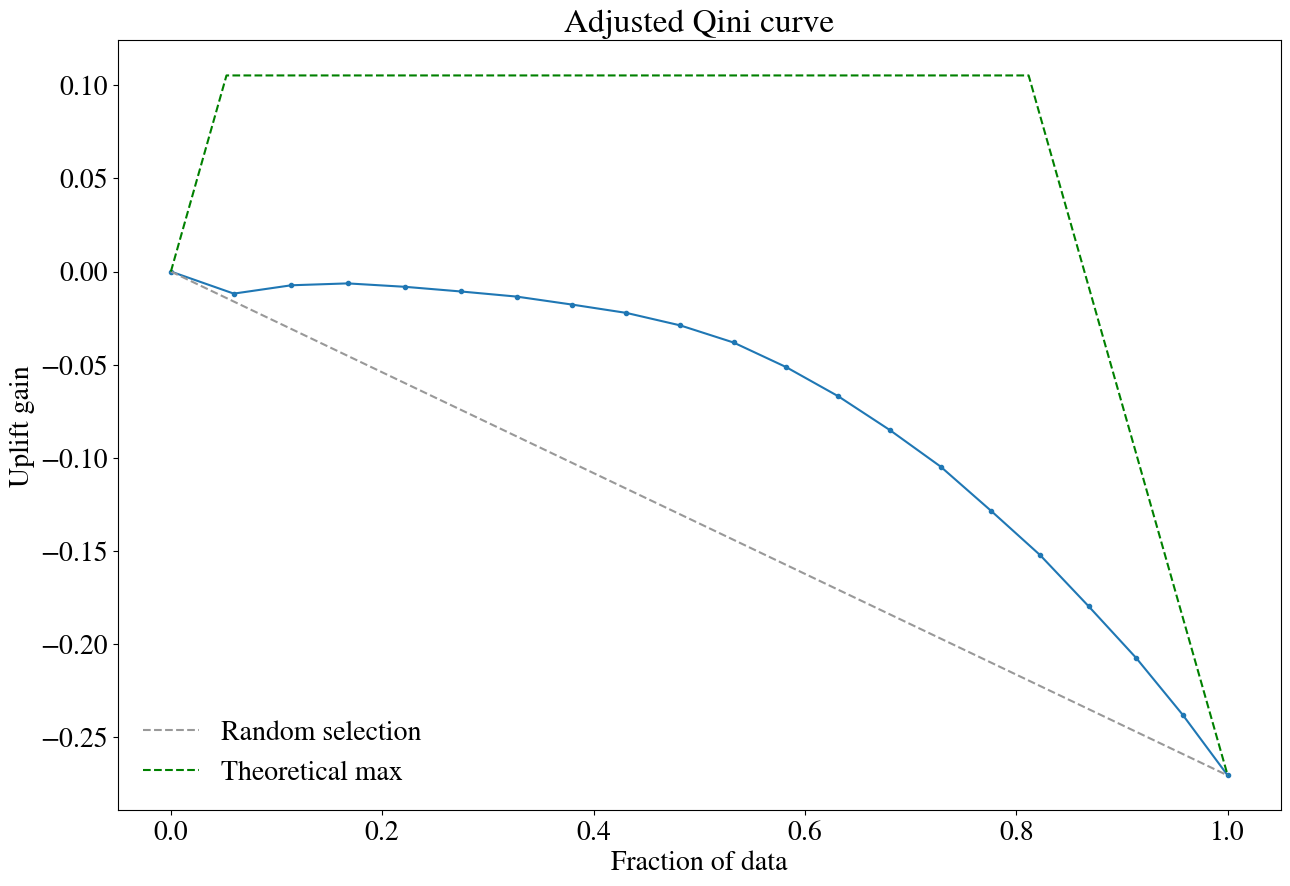

In [67]:
up.plot(plot_type='aqini',show_theoretical_max=True)

<Axes: title={'center': 'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

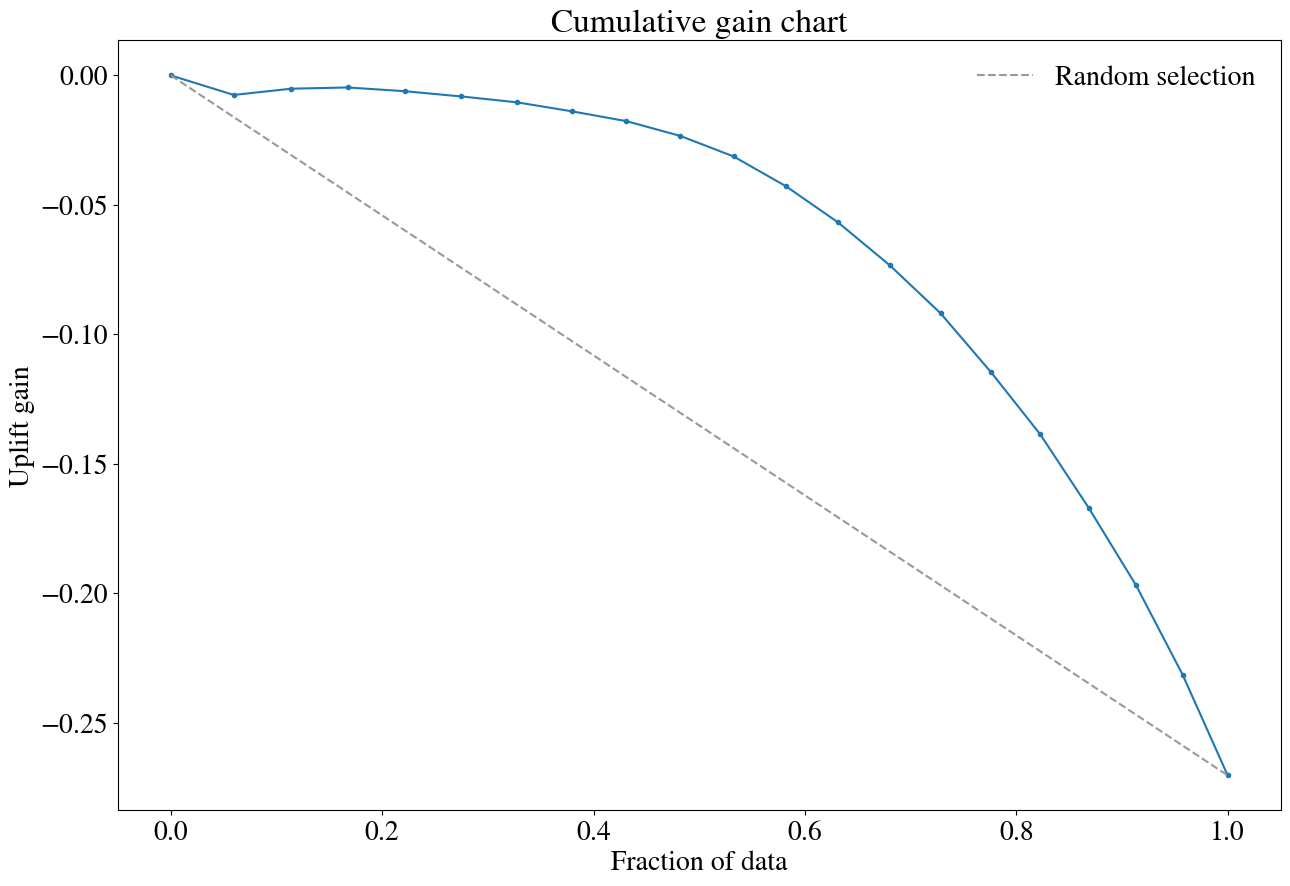

In [68]:
up.plot()

In [69]:
up.model.feature_importances_

array([2.17382068, 1.48093269, 0.95709405, 0.76058207, 0.68246988,
       0.71830101, 0.70435318, 1.26517967, 2.92713277, 3.96951239,
       4.77226337, 2.6775884 , 1.19050978, 0.73792404, 0.85233636,
       0.59883727, 8.17742154, 0.50778033, 0.59397548, 0.70418231,
       1.31507696, 1.34154741, 3.64017204, 1.53790121, 5.34980897,
       1.33677382, 0.88267267, 0.17235269, 0.42116   , 0.83565978,
       1.61226156, 0.04931784, 0.06786901, 0.04792798, 1.82291216,
       0.96804432, 0.28670935, 1.19631556, 2.33470724, 0.71530359,
       0.34898523, 0.2536539 , 0.31155468, 0.58621434, 0.97776796,
       0.66210539, 0.67660561, 0.1760014 , 2.83527871, 0.86530388,
       1.12515927, 0.94110152, 1.0281109 , 1.20834931, 0.8460214 ,
       1.79588727, 3.11196868, 1.36200833, 0.9586716 , 1.58898545,
       1.14655657, 1.23313324, 0.85409126, 1.35619998, 4.42446454,
       1.82210287, 3.13336558, 1.00632757, 0.97733212])

In [19]:
name = 'AAC_newdata'

In [20]:
import joblib

joblib.dump(up.model, 'submissions/'+name+'/models/uplift.joblib')

['submissions/AAC_newdata/models/uplift.joblib']

In [127]:
#get unique customers

customers = data.customer.unique()

In [130]:
customers = pd.DataFrame(customers,columns=['customer'])

In [131]:
customers

,customer
0,168972
1,212404
2,225178
3,183948
4,210107
...,...
462579,58320
462580,403494
462581,420508
462582,147433


In [21]:
#get train data by taking 10% of customers

randomlist = random.sample(list(data.customer.unique()),int(0.1*len(data.customer.unique())))
testdata = data[data['customer'].isin(randomlist)]

NameError: name 'data' is not defined

In [145]:
testdata

,ind_recommended,activation,customer_digital_activity_04,customer_spend_01,customer_industry_spend_01,customer_industry_spend_02,customer_industry_spend_03,customer_industry_spend_04,customer_industry_spend_05,customer_spend_02,...,merchant_spend_09,merchant_profile_03,customer_digital_activity_01,merchant_spend_10,customer_profile_03,customer_digital_activity_02,customer_profile_04,distance_05,customer,merchant
2,0,0,NaN,31.623103,48.837872,19.0,2295.38,47.0,42.0,11.0,...,3912.0,12868.0,0.836364,421.500000,33.780445,0.000000,180.0,1.753009,225178,7439
10,0,0,NaN,196.890000,NaN,NaN,NaN,NaN,NaN,1.0,...,3682.0,2805.0,0.960000,14.861765,100.000000,0.500000,9.0,7.568990,159066,439468
30,0,0,NaN,320.226923,NaN,NaN,NaN,NaN,NaN,7.0,...,1811.0,5074.0,1.000000,25.060000,0.000000,0.000000,51.0,17.790009,196106,53653
36,0,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20957.0,31634.0,0.000000,75.885000,1.851870,1.333333,96.0,13.684754,311824,244117
43,0,0,NaN,57.817273,35.770000,3.0,286.16,8.0,8.0,5.0,...,NaN,NaN,1.000000,278.410000,66.565518,29.166667,317.0,5.120346,82596,274748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12229949,0,1,NaN,14.078333,NaN,NaN,NaN,NaN,NaN,3.0,...,6668.0,11388.0,0.340426,144.000000,100.000000,2.833333,437.0,2.070041,21972,568383
12229953,0,1,1.0,140.238462,35.980000,1.0,35.98,1.0,1.0,7.0,...,6496.0,6374.0,0.384615,27.979231,72.387554,3.333333,463.0,0.673134,22203,110930
12229954,0,1,4.0,82.731667,79.477500,6.0,953.73,12.0,11.0,4.0,...,10522.0,49975.0,1.000000,63.240000,59.078620,2.666667,446.0,0.222711,22214,7453
12229963,0,1,4.0,45.414681,37.836283,54.0,4275.50,113.0,99.0,19.0,...,22269.0,7627.0,0.125000,43.982500,85.412580,0.666667,363.0,3.105397,22681,34861


In [19]:
testdata['predicted_score'] = up.model.predict(testdata.drop(['activation','ind_recommended'],axis=1))

In [20]:
eval(testdata[['customer','predicted_score','merchant']],testdata[['customer','ind_recommended','activation','merchant']])

Input Files are Correct
   ind_recommended  avg_30d_act
0                0     0.247189
1                1     0.192297
Incremental Activation Rate for Top 10 ranked Merchants(dataset level):  -0.0548926


/var/folders/yy/95rx0nm12jqc32p5svcxxv7h0000gn/T/ipykernel_67182/393397306.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['predicted_score'] = df_input['predicted_score'].round(10)


In [21]:
name='uplift_model_catboost_newdata'

In [22]:
cols =['customer_digital_activity_04',
       'customer_spend_01', 'customer_industry_spend_01',
       'customer_industry_spend_02', 'customer_industry_spend_03',
       'customer_industry_spend_04', 'customer_industry_spend_05',
       'customer_spend_02', 'customer_spend_03', 'customer_merchant_02',
       'customer_merchant_01', 'customer_spend_04', 'customer_spend_05',
       'customer_spend_06', 'customer_spend_07', 'merchant_spend_01',
       'merchant_spend_02', 'merchant_spend_03', 'merchant_spend_04',
       'merchant_spend_05', 'merchant_spend_06', 'merchant_spend_07',
       'merchant_spend_08', 'merchant_profile_01', 'customer_merchant_03',
       'customer_profile_01', 'customer_profile_02',
       'customer_digital_activity_05', 'customer_spend_13',
       'customer_digital_activity_06', 'customer_spend_14',
       'customer_digital_activity_07', 'customer_digital_activity_08',
       'customer_digital_activity_09', 'customer_digital_activity_10',
       'customer_digital_activity_11', 'customer_digital_activity_12',
       'customer_digital_activity_13', 'customer_digital_activity_14',
       'customer_digital_activity_15', 'customer_spend_15',
       'customer_digital_activity_16', 'customer_spend_16',
       'customer_spend_17', 'customer_digital_activity_17',
       'customer_digital_activity_03', 'merchant_spend_11',
       'customer_digital_activity_18', 'customer_digital_activity_19',
       'distance_01', 'customer_digital_activity_20', 'distance_02',
       'distance_03', 'customer_spend_18', 'customer_spend_19',
       'customer_digital_activity_21', 'customer_digital_activity_22',
       'distance_04', 'merchant_profile_02', 'merchant_spend_09',
       'merchant_profile_03', 'customer_digital_activity_01',
       'merchant_spend_10', 'customer_profile_03',
       'customer_digital_activity_02', 'customer_profile_04', 'distance_05','customer', 'merchant']

In [23]:
evaldata = pd.read_parquet('Data/Evaluation/Amex_Campus_Challenge_Eval_Round1.parquet')

In [24]:
evaldata = evaldata[cols]

In [25]:
evaldata

,customer_digital_activity_04,customer_spend_01,customer_industry_spend_01,customer_industry_spend_02,customer_industry_spend_03,customer_industry_spend_04,customer_industry_spend_05,customer_spend_02,customer_spend_03,customer_merchant_02,...,merchant_spend_09,merchant_profile_03,customer_digital_activity_01,merchant_spend_10,customer_profile_03,customer_digital_activity_02,customer_profile_04,distance_05,customer,merchant
0,NaN,112.334000,80.552500,9.0,966.63,12.0,10.0,4.0,41.0,NaN,...,26299.0,4777.0,0.800000,33.300,72.268283,7.000000,423.0,1.621171,467915,599167
1,NaN,112.334000,NaN,NaN,NaN,NaN,NaN,4.0,41.0,NaN,...,7122.0,4803.0,0.800000,793.290,72.268283,7.000000,423.0,2.441944,467915,686617
2,NaN,112.334000,71.192500,3.0,284.77,4.0,4.0,4.0,41.0,NaN,...,7222.0,14860.0,0.800000,100.000,72.268283,7.000000,423.0,2.438082,467915,829193
3,NaN,112.334000,NaN,NaN,NaN,NaN,NaN,4.0,41.0,NaN,...,11410.0,11968.0,0.800000,252.380,72.268283,7.000000,423.0,2.072182,467915,1077034
4,NaN,302.792500,NaN,NaN,NaN,NaN,NaN,3.0,37.0,NaN,...,1847.0,5842.0,0.800000,87.500,72.268283,7.000000,423.0,2.380853,467915,876647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8496461,NaN,65.181875,171.463500,8.0,3429.27,20.0,16.0,21.0,94.0,NaN,...,25017.0,29209.0,0.000000,49.500,92.116548,1.666667,270.0,22.197181,464447,644485
8496462,NaN,15.680000,11.095556,5.0,99.86,9.0,8.0,2.0,14.0,NaN,...,39731.0,3529.0,0.733333,32.440,34.500012,0.166667,24.0,17.812486,522564,802309
8496463,NaN,61.723409,NaN,NaN,NaN,NaN,NaN,11.0,112.0,NaN,...,2994.0,7534.0,1.000000,198.500,50.484705,0.166667,390.0,8.299482,465030,741321
8496464,NaN,270.908125,31.177692,4.0,405.31,13.0,6.0,10.0,28.0,NaN,...,423.0,241.0,0.916667,33.000,86.240872,0.333333,310.0,4.665418,495259,625845


In [26]:
evaldata['predicted_score'] = up.model.predict(evaldata)

In [27]:
evaldata.dtypes

customer_digital_activity_04    float64
customer_spend_01               float64
customer_industry_spend_01      float64
customer_industry_spend_02      float64
customer_industry_spend_03      float64
                                 ...   
customer_profile_04             float64
distance_05                     float64
customer                          int64
merchant                          int64
predicted_score                 float64
Length: 70, dtype: object

In [28]:
evaldata['predicted_score'].mean()

0.062409978632488206

In [30]:
import os

In [31]:
#makedirectory
os.mkdir('submissions/'+name)

In [32]:
evaldata[['customer','predicted_score','merchant']].to_csv('submissions/'+name+'/submissionw.csv',index=False)